In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/EE137/ecg_matlab
# just upload the data folder to your drive ** i wasn't able to access the shared with me folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1F6dOmt_qav0uuQ5vNcV-7Nyk2bMhTC9l/EE137/ecg_matlab


In [2]:
!pip install scaleogram

In [3]:
!pip install PyWavelets


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scaleogram as scg 
import pywt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
'''
Function read_from_mat is for reading .mat file in numpy format, at the same time
class label is converted to one-hot encoding  
'''
def read_from_mat(data_file_name, label_file_name):
  data = loadmat(data_file_name, struct_as_record=False,squeeze_me=True)
  lb = loadmat(label_file_name)
  ecg_data = data['ECGData'].Data
  ecg_lb = np.squeeze(lb['label']) - 1
  # convert label to one-hot
  shape = (ecg_lb.size, ecg_lb.max() + 1)
  one_hot_lb = np.zeros(shape)
  rows = np.arange(ecg_lb.size)
  one_hot_lb[rows, ecg_lb] = 1
  return ecg_data, ecg_lb, one_hot_lb
'''
Function sliding_window_seg is used to segment data depending on window_size and stride,
If window_size == stride, then no overlap. 
'''
def sliding_window_seg(data, label, window_size, stride=1000):
    trunc_data = data
    print(trunc_data.shape)
    modulo = np.mod(trunc_data.shape[1]-window_size, stride)
    print(modulo)
    data_all = trunc_data[:,modulo:]
    row_num = int(((data_all.shape[1] - window_size)// stride + 1) * trunc_data.shape[0])
    num_chunk = int((data_all.shape[1] - window_size)// stride + 1)
    new_data = np.zeros((row_num, window_size))
    print(new_data.shape)
    new_label = np.zeros((row_num, label.shape[1]))
    print(new_label.shape)
    for i in range(data_all.shape[0]):
      for j in range(num_chunk):
        new_data[i * num_chunk + j] = data_all[i, j * window_size: (j + 1)* window_size]
        new_label[i * num_chunk + j] = label[i] 
    return new_data, new_label 

In [9]:
ecg_data, _, ecg_label = read_from_mat('ECGData.mat', 'ecg_label.mat')
ecg_data_new, ecg_label_new = sliding_window_seg(ecg_data, ecg_label, 1000, stride = 1000 )
print(ecg_data_new.shape)
print(ecg_label_new.shape)

(162, 65536)
536
(10530, 1000)
(10530, 3)
(10530, 1000)
(10530, 3)


In [10]:
'''
Number of training data is ratio * data.shape[0]
'''
def train_test_split(data, label, ratio):
    # shuffle train data
    perm = np.arange(data.shape[0])
    np.random.shuffle(perm)
    X = data[perm]
    y = label[perm]
    train_idx = int(data.shape[0] * ratio)
    X_train, X_test = X[:train_idx], X[train_idx:]
    y_train, y_test = y[:train_idx], y[train_idx:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(ecg_data_new, ecg_label_new, 0.8)

In [11]:
X_train.shape

(8424, 1000)

In [12]:
from skimage.transform import resize
def create_cwt_image(X, n_scales, rescale_size, wavelet_name = "morl", n_channels = 1):
  n_samples = X.shape[0]
  
  scales = np.arange(1, n_scales + 1)
  X_cwt = np.ndarray(shape = (n_samples, rescale_size, rescale_size, n_channels), dtype = 'float32')
  for sample in range(n_samples):
      #print(sample)
      for signal in range(n_channels):
        serie = X[sample]
        coeffs, freq = pywt.cwt(serie, scales, wavelet_name)
        rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
        #print(rescale_coeffs, 'fdasfdsjfkhlaksjdfhakjlsdhflkasdhfkljadshkflj')
        X_cwt[sample, :,:, signal] = rescale_coeffs
  return X_cwt

In [13]:
rescale_size = 64
n_scales = 64
X_train_cwt = create_cwt_image(X_train, n_scales, rescale_size)
X_test_cwt = create_cwt_image(X_test, n_scales, rescale_size)

In [14]:
X_test_cwt[600]

array([[[ 5.3058518e-04],
        [ 1.6079686e-03],
        [-1.1699852e-03],
        ...,
        [-3.2627591e-04],
        [ 1.6242644e-03],
        [-2.4347727e-03]],

       [[-5.2345684e-04],
        [-1.9353589e-05],
        [ 5.8216774e-06],
        ...,
        [ 3.0223387e-06],
        [-5.4459942e-06],
        [ 8.6414587e-04]],

       [[-1.3838114e-03],
        [ 3.5453492e-04],
        [-3.1897769e-04],
        ...,
        [-8.2588434e-05],
        [ 3.9468711e-04],
        [ 2.2996068e-03]],

       ...,

       [[-1.3910391e+00],
        [-9.3443376e-01],
        [ 1.1824228e+00],
        ...,
        [-1.8763237e+00],
        [-1.0738070e+00],
        [ 6.0249692e-01]],

       [[-1.4243041e+00],
        [-8.8192654e-01],
        [ 1.2208852e+00],
        ...,
        [-1.8988549e+00],
        [-1.1209810e+00],
        [ 5.4483855e-01]],

       [[-1.4081235e+00],
        [-8.4434927e-01],
        [ 1.2607648e+00],
        ...,
        [-1.8797975e+00],
        [-1.202

In [15]:

def get_wav_model(input_shape, stride=2, dim = 1):
  # input_shape should be a list with the first element as length, the second 
  # element as width
  inputs = layers.Input(shape =(input_shape[0], input_shape[1], dim), name = 'input')
  x = layers.Conv2D(filters=32, kernel_size = 3, activation ='relu',padding='same',strides=stride)(inputs)
  x = layers.Conv2D(filters=64, kernel_size=3, activation='relu',padding='same',strides=stride)(x)
  #x = layers.Dropout(0.2)(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  outputs = layers.Flatten()(x)
  outputs = layers.Dense(128, activation= 'tanh')(outputs)
  outputs = layers.Dense(64, activation='tanh')(outputs)
  outputs = layers.Dense(num_classes, activation='softmax')(outputs)
  wav_model = keras.Model(inputs, outputs = outputs)
  return wav_model

In [16]:
num_classes = 3
input_shape = [64, 64]
wav_model =  get_wav_model(input_shape)
wav_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [17]:
wav_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               524416    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256  

In [21]:
wav_trace = wav_model.fit(x=X_train_cwt, y=y_train, batch_size=16, epochs=100, verbose=1, validation_split=0.3, shuffle=True)

Epoch 1/100
369/369 [==============================] - 2s 4ms/step - loss: 0.1972 - categorical_accuracy: 0.9520 - val_loss: 0.6927 - val_categorical_accuracy: 0.7872
Epoch 2/100
369/369 [==============================] - 1s 4ms/step - loss: 0.1322 - categorical_accuracy: 0.9512 - val_loss: 0.7743 - val_categorical_accuracy: 0.8271
Epoch 3/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0332 - categorical_accuracy: 0.9885 - val_loss: 0.8236 - val_categorical_accuracy: 0.8378
Epoch 4/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0182 - categorical_accuracy: 0.9947 - val_loss: 0.7937 - val_categorical_accuracy: 0.8386
Epoch 5/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0246 - categorical_accuracy: 0.9922 - val_loss: 0.8666 - val_categorical_accuracy: 0.8461
Epoch 6/100
369/369 [==============================] - 1s 4ms/step - loss: 0.0175 - categorical_accuracy: 0.9944 - val_loss: 0.9929 - val_categorical_accuracy: 0.828

In [22]:
y_pred = wav_model.predict(X_test_cwt)

acc = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))

print('The test accuracy is ', acc)

The test accuracy is  0.828584995251662


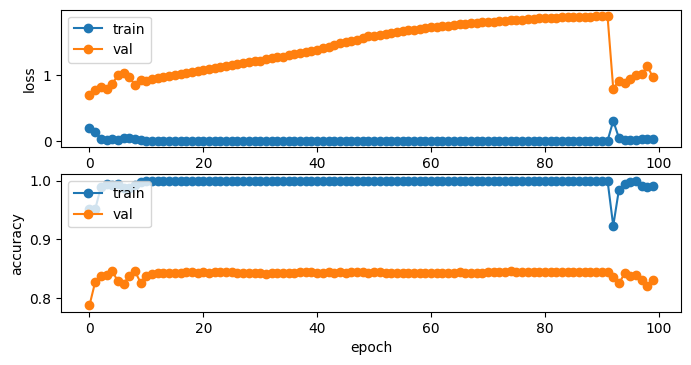

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4),dpi=100)

plt.subplot(2, 1, 1)
plt.plot(wav_trace.history['loss'], '-o')
plt.plot(wav_trace.history['val_loss'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(wav_trace.history['categorical_accuracy'], '-o')
plt.plot(wav_trace.history['val_categorical_accuracy'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()